## Victor Gómez
### victor.gomez@cimat.mx


# Maestría en Cómputo Estadístico
# CIMAT Monterrey

# <center>Tópicos selectos de Cómputo<center>
# <center>Tarea 1: Valores faltantes<center>

Instrucciones: 
- Usa python 3.x , tensorflow 2.x y xgboost 1.x
- ejecuta todas las celdas para replicar los resultados

In [16]:
#Librerías necesarias
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import  cross_val_score, RepeatedKFold, RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from baycomp import *

# Clase que realiza la imputación de datos faltantes en un DataFrame por distintos métodos.

## Métodos de imputación de valores faltantes:

- 1 Métodos no estadísticos: LOCF (Last observation carried forward)
- 2 Métodos estadísticos:    mean_mode (media para atributos numéricos, moda para atributos categoricos)

Métodos de Machine Learning. Ajuste mediante RandomizedSearchCV con 3-Fold: 
- 3 Vecinos mas cercanos: knn (KNeighbors: k: [2-40])
- 4 Arboles de decisión:  trees (XGBoost: learning rate: [0.1-0.6], n_estimators: [50-300], subsample: 0.9, regularización: gamma: [0-100], lambda: [1-10])
- 5 Redes neuronales:     MLP (epocas: 100, optimizador: adam, función de costo: binary_crossentropy(o categorical_crossentropy), metrica: accuracy, hiddenlayers:  2 con 50 neuronas, función de activación: relu. outputlayer: función de activación: sigmoid (o softmax) con 1 (o número de clases) neuronas.)

In [2]:
from _missing_value import MissingValueImputation #Clase que realiza la imputacion de datos faltantes en un DataFrame por distintos metodos

## Conjuntos de datos con valores faltantes (%MVs):
datasets de: https://sci2s.ugr.es/keel/missing.php

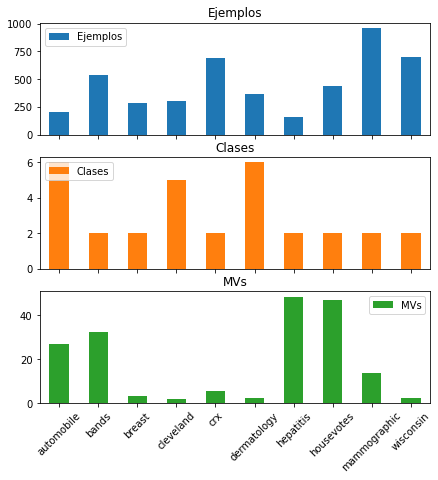

In [3]:
names=['automobile','bands','breast','cleveland','crx','dermatology','hepatitis','housevotes','mammographic','wisconsin']
Ejemplos=[205,539,286,303,690,366,155,435,961,699]
clases=[6,2,2,5,2,6,2,2,2,2]
mvs=[26.83,32.28,3.15,1.98,5.36,2.19,48.39,46.67,13.63,2.29]

df_mvs_dict={
            'Ejemplos': Ejemplos,
             'Clases': clases,
             'MVs': mvs}

df_mvs=pd.DataFrame(df_mvs_dict)
df_mvs.index=names

axes = df_mvs.plot.bar(rot=45, subplots=True,figsize=(7,7))
axes[1].legend(loc=2)  

Los 10 conjuntos de datos presentan diferentes características, la cantidad de ejemplos que  esta entre 250 y 1000, la mayoría son de 2 clases, máximo 6 y de 5 a 50% de datos faltantes.

## Modelos de ML para clasificación. Ajuste mediante RandomizedSearchCV con validación cruzada (10x2) y metrica accuracy:

- 1 KNeighbors: k: [2-40]
- 2 XGBoost: learning rate: [0.1-0.6], n_estimators: [50-300], subsample: 0.9, regularización: gamma: [0-100], lambda: [1-10]
- 3 MLP, epocas: 100, optimizador: adam, función de costo: binary_crossentropy(o categorical_crossentropy), hiddenlayers:  2 con 50 neuronas, función de activación: relu. outputlayer: función de activación: sigmoid (o softmax) con 1 (o número de clases) neuronas. 


In [40]:
def df_clean(df): #libera memoria
    df=pd.DataFrame()
    del df
    
#Models:
#K Neighbors
def KNN_model():
    params={'n_neighbors':np.random.randint(2,40, size=10)}
    return KNeighborsClassifier(), params

#XGBoost
def XGBoost_model(num_classes=2):
    
    gbm_param_grid={'learning_rate':[0.1,0.3,0.6],
               'n_estimators':[50,150,300],
               'subsample':[0.9],
               'gamma':[0,10,100],
               'lambda':[1,10,100]}
    
    if num_classes ==2:
        gbm=xgb.XGBClassifier()
                
    else:
        gbm=xgb.XGBClassifier(objective='multi:softmax')
    
    return gbm, gbm_param_grid 



#MLP
def create_model(input_features,neurons_output,activation,loss):
    neur_Hid_layer=[50,50]
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neur_Hid_layer[0],activation='relu',input_shape=(input_features,))) #first layer
    model.add(tf.keras.layers.BatchNormalization()) #batch normalization
        
    layers=len(neur_Hid_layer)
        
    if layers>1: #next hidden layers
        for layer in range(1,layers):
            model.add(tf.keras.layers.Dense(neur_Hid_layer[layer],activation='relu'))
            model.add(tf.keras.layers.BatchNormalization()) #batch normalization
        
    if activation!='linear':
        model.add(tf.keras.layers.Dense(neurons_output,activation=activation)) #output layer
    else:
        model.add(tf.keras.layers.Dense(neurons_output)) #output layer
    
    
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy']) #compìla el modelo
        
    return model

rkf = RepeatedKFold(n_splits=2, n_repeats=10)

#Cross validation 
def model_train_CV_(model,params,X_train,y_train,cv=rkf): 
    kfold=RandomizedSearchCV(model,param_distributions=params,scoring='accuracy',cv=cv,n_jobs=-1)
    kfold.fit(X_train,y_train)
    score=kfold.best_score_
    return score



#prepara los datos, entrena, y obtiene scores para cada modelo
def Data_Prer_Mod_train(df,model_name,cv=rkf): 
    _,column=df.shape
    column=column-1
    flat= lambda x,num_features: x.reshape([-1, num_features]) # Flatten function
    if model_name=='KNN':
        y=df.iloc[:,column].values
        X=pd.get_dummies(df.drop([column],axis=1),drop_first=True).values
        scaler = StandardScaler() #Standardize
        scaler.fit(X)
        X=scaler.transform(X)
        model,params=KNN_model()
        score=model_train_CV_(model,params,X,y,cv)
        
    elif model_name=='XGB':
        y=df.iloc[:,column].values
        X=pd.get_dummies(df.drop([column],axis=1),drop_first=True).values
        num_classes=np.shape(df.iloc[:,column].unique())[0]
        model,params=XGBoost_model(num_classes)
        score=model_train_CV_(model,params,X,y,cv)
    elif model_name=='MLP':
        y=df.iloc[:,column].values
        X=pd.get_dummies(df.drop([column],axis=1),drop_first=True).values
        num_classes=np.shape(df.iloc[:,column].unique())[0]
        num_features=X.shape[1]
        scaler = StandardScaler() #Standardize
        scaler.fit(X)
        X=scaler.transform(X)
        X=flat(X,num_features) #flatten
        
        if num_classes==2:
            y=np.reshape(y,(-1, 1))
            enc=OneHotEncoder(drop='first').fit(y)
            y = enc.transform(y).toarray()
            lossf='binary_crossentropy'
            activ_output='sigmoid'
            neurons_output=1
            
        else:
            y=np.reshape(y,(-1, 1))
            enc=OneHotEncoder().fit(y)
            y = enc.transform(y).toarray()
            lossf='categorical_crossentropy'
            activ_output='softmax'
            neurons_output=num_classes
        
        model=KerasClassifier(build_fn=create_model, epochs=100,  input_features=num_features,neurons_output=neurons_output,activation=activ_output,loss=lossf)

        kfold=cross_val_score(model,X,y,cv=cv,n_jobs=-1)
        score=kfold.mean()
        
    return np.round(score,2)

# 1.- Importación de los conjuntos de datos, Imputación de los datos faltantes, Ajuste de modelos y Validacion cruzada (10x2).

In [5]:
startTime = datetime.now()
#importa los conjuntos de datos
names=['automobile','bands','breast','cleveland','crx','dermatology','hepatitis','housevotes','mammographic','wisconsin']
methods=['LOCF','mean_mode','knn','trees','MLP']
models=['KNN','XGB','MLP']
results_LOCF=[]
results_mean_mode=[]
results_knn=[]
results_trees=[]
results_MLP=[]
for name in names: #abre los conjuntos de datos
    DataFrame = pd.read_csv(name+'.csv', header=None, na_values=[' ','  ','?',None])
    for method in methods: # imputa datos faltantes con cada metodo
        df_complete_i = MissingValueImputation(method = method).fit_transform(DataFrame)
        for model in models: #ajusta modelos de Machine Learning
            result=Data_Prer_Mod_train(df_complete_i,model)
            #imprime y guarda resultados
            print('DataFrame: '+name+' imput_method :'+method+' model :'+model+' score: ',result)
            if method=='LOCF':
                results_LOCF.append(result)
            elif method=='mean_mode':
                results_mean_mode.append(result)
            elif method=='knn':
                results_knn.append(result)
            elif method=='trees':
                results_trees.append(result)
            elif method=='MLP':
                results_MLP.append(result)
        df_clean(df_complete_i) #libera memoria
    df_clean(DataFrame) #libera memoria
print('Tiempo total: ',datetime.now() - startTime) #tiempo total

DataFrame: automobile imput_method :LOCF model :KNN score:  0.49
DataFrame: automobile imput_method :LOCF model :XGB score:  0.73


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: automobile imput_method :LOCF model :MLP score:  0.64
DataFrame: automobile imput_method :mean_mode model :KNN score:  0.5
DataFrame: automobile imput_method :mean_mode model :XGB score:  0.73
DataFrame: automobile imput_method :mean_mode model :MLP score:  0.65
DataFrame: automobile imput_method :knn model :KNN score:  0.53
DataFrame: automobile imput_method :knn model :XGB score:  0.74
DataFrame: automobile imput_method :knn model :MLP score:  0.64
Best score is -12.139809991427677
Best score is 0.9015949663447468
Best score is -0.05837722617002269
Best score is -0.08714400604589662
Best score is -7.216644583789445
Best score is -103.73169252542435
Best score is -1585.585833041822
DataFrame: automobile imput_method :trees model :KNN score:  0.54
DataFrame: automobile imput_method :trees model :XGB score:  0.76
DataFrame: automobile imput_method :trees model :MLP score:  0.66
Train on 159 samples, validate on 159 samples
Epoch 1/100
159/159 [==============================] 

Epoch 51/100
159/159 [==============================] - 0s 189us/sample - loss: 112.0226 - mae: 112.0227 - val_loss: 111.6845 - val_mae: 111.6845
Epoch 52/100
159/159 [==============================] - 0s 182us/sample - loss: 111.6799 - mae: 111.6799 - val_loss: 111.3471 - val_mae: 111.3471
Epoch 53/100
159/159 [==============================] - 0s 179us/sample - loss: 111.3306 - mae: 111.3306 - val_loss: 111.0040 - val_mae: 111.0040
Epoch 54/100
159/159 [==============================] - 0s 176us/sample - loss: 110.9748 - mae: 110.9748 - val_loss: 110.6373 - val_mae: 110.6373
Epoch 55/100
159/159 [==============================] - 0s 182us/sample - loss: 110.6124 - mae: 110.6124 - val_loss: 110.2610 - val_mae: 110.2611
Epoch 56/100
159/159 [==============================] - 0s 176us/sample - loss: 110.2436 - mae: 110.2436 - val_loss: 109.8756 - val_mae: 109.8756
Epoch 57/100
159/159 [==============================] - 0s 182us/sample - loss: 109.8682 - mae: 109.8682 - val_loss: 109.482

159/159 [==============================] - 0s 189us/sample - loss: 0.3493 - accuracy: 0.8805 - val_loss: 0.5304 - val_accuracy: 0.7484
Epoch 7/100
159/159 [==============================] - 0s 182us/sample - loss: 0.3112 - accuracy: 0.8994 - val_loss: 0.4947 - val_accuracy: 0.7736
Epoch 8/100
159/159 [==============================] - 0s 182us/sample - loss: 0.2998 - accuracy: 0.9308 - val_loss: 0.4631 - val_accuracy: 0.8113
Epoch 9/100
159/159 [==============================] - 0s 189us/sample - loss: 0.2543 - accuracy: 0.9308 - val_loss: 0.4340 - val_accuracy: 0.8553
Epoch 10/100
159/159 [==============================] - 0s 189us/sample - loss: 0.2453 - accuracy: 0.9245 - val_loss: 0.4083 - val_accuracy: 0.8742
Epoch 11/100
159/159 [==============================] - 0s 182us/sample - loss: 0.2259 - accuracy: 0.9308 - val_loss: 0.3836 - val_accuracy: 0.8994
Epoch 12/100
159/159 [==============================] - 0s 182us/sample - loss: 0.1930 - accuracy: 0.9497 - val_loss: 0.3613 - v

159/159 [==============================] - 0s 191us/sample - loss: 2.6299 - mae: 2.6299 - val_loss: 2.2027 - val_mae: 2.2027
Epoch 12/100
159/159 [==============================] - 0s 189us/sample - loss: 2.5529 - mae: 2.5529 - val_loss: 2.1120 - val_mae: 2.1120
Epoch 13/100
159/159 [==============================] - 0s 189us/sample - loss: 2.4732 - mae: 2.4732 - val_loss: 2.0144 - val_mae: 2.0144
Epoch 14/100
159/159 [==============================] - 0s 182us/sample - loss: 2.3889 - mae: 2.3889 - val_loss: 1.9211 - val_mae: 1.9211
Epoch 15/100
159/159 [==============================] - 0s 189us/sample - loss: 2.2903 - mae: 2.2903 - val_loss: 1.8262 - val_mae: 1.8262
Epoch 16/100
159/159 [==============================] - 0s 189us/sample - loss: 2.1931 - mae: 2.1931 - val_loss: 1.7356 - val_mae: 1.7356
Epoch 17/100
159/159 [==============================] - 0s 176us/sample - loss: 2.1105 - mae: 2.1105 - val_loss: 1.6166 - val_mae: 1.6166
Epoch 18/100
159/159 [=========================

159/159 [==============================] - 0s 147us/sample - loss: 92.0531 - mae: 92.0531 - val_loss: 92.1333 - val_mae: 92.1333
Epoch 33/100
159/159 [==============================] - 0s 145us/sample - loss: 91.8350 - mae: 91.8350 - val_loss: 91.9180 - val_mae: 91.9180
Epoch 34/100
159/159 [==============================] - 0s 135us/sample - loss: 91.6105 - mae: 91.6105 - val_loss: 91.6946 - val_mae: 91.6946
Epoch 35/100
159/159 [==============================] - 0s 138us/sample - loss: 91.3794 - mae: 91.3794 - val_loss: 91.4614 - val_mae: 91.4615
Epoch 36/100
159/159 [==============================] - 0s 145us/sample - loss: 91.1418 - mae: 91.1418 - val_loss: 91.2311 - val_mae: 91.2311
Epoch 37/100
159/159 [==============================] - 0s 137us/sample - loss: 90.8977 - mae: 90.8977 - val_loss: 90.9868 - val_mae: 90.9868
Epoch 38/100
159/159 [==============================] - 0s 138us/sample - loss: 90.6471 - mae: 90.6471 - val_loss: 90.7345 - val_mae: 90.7345
Epoch 39/100
159/15

159/159 [==============================] - 0s 132us/sample - loss: 69.2438 - mae: 69.2438 - val_loss: 67.1061 - val_mae: 67.1061
Epoch 90/100
159/159 [==============================] - 0s 145us/sample - loss: 68.6578 - mae: 68.6578 - val_loss: 66.5620 - val_mae: 66.5620
Epoch 91/100
159/159 [==============================] - 0s 132us/sample - loss: 68.0656 - mae: 68.0656 - val_loss: 66.0255 - val_mae: 66.0255
Epoch 92/100
159/159 [==============================] - 0s 151us/sample - loss: 67.4670 - mae: 67.4670 - val_loss: 65.4703 - val_mae: 65.4703
Epoch 93/100
159/159 [==============================] - 0s 143us/sample - loss: 66.8622 - mae: 66.8622 - val_loss: 64.9260 - val_mae: 64.9260
Epoch 94/100
159/159 [==============================] - 0s 145us/sample - loss: 66.2512 - mae: 66.2512 - val_loss: 64.3709 - val_mae: 64.3709
Epoch 95/100
159/159 [==============================] - 0s 130us/sample - loss: 65.6340 - mae: 65.6340 - val_loss: 63.8039 - val_mae: 63.8039
Epoch 96/100
159/15

159/159 [==============================] - 0s 138us/sample - loss: 5107.2123 - mae: 5107.2129 - val_loss: 5106.9561 - val_mae: 5106.9565
Epoch 44/100
159/159 [==============================] - 0s 138us/sample - loss: 5106.9215 - mae: 5106.9214 - val_loss: 5106.6665 - val_mae: 5106.6665
Epoch 45/100
159/159 [==============================] - 0s 134us/sample - loss: 5106.6237 - mae: 5106.6235 - val_loss: 5106.3702 - val_mae: 5106.3701
Epoch 46/100
159/159 [==============================] - 0s 136us/sample - loss: 5106.3192 - mae: 5106.3193 - val_loss: 5106.0669 - val_mae: 5106.0669
Epoch 47/100
159/159 [==============================] - 0s 147us/sample - loss: 5106.0085 - mae: 5106.0088 - val_loss: 5105.7561 - val_mae: 5105.7563
Epoch 48/100
159/159 [==============================] - 0s 131us/sample - loss: 5105.6912 - mae: 5105.6914 - val_loss: 5105.4352 - val_mae: 5105.4351
Epoch 49/100
159/159 [==============================] - 0s 144us/sample - loss: 5105.3672 - mae: 5105.3672 - val_

Epoch 98/100
159/159 [==============================] - 0s 138us/sample - loss: 5081.6075 - mae: 5081.6079 - val_loss: 5081.3881 - val_mae: 5081.3882
Epoch 99/100
159/159 [==============================] - 0s 132us/sample - loss: 5080.9650 - mae: 5080.9648 - val_loss: 5080.7681 - val_mae: 5080.7681
Epoch 100/100
159/159 [==============================] - 0s 52us/sample - loss: 5080.1276 - mae: 5080.1279
Val score is 5080.1279296875
Train on 159 samples, validate on 159 samples
Epoch 1/100
159/159 [==============================] - 1s 5ms/sample - loss: 11445.7075 - mae: 11445.7070 - val_loss: 11446.1926 - val_mae: 11446.1924
Epoch 2/100
159/159 [==============================] - 0s 145us/sample - loss: 11445.6510 - mae: 11445.6514 - val_loss: 11446.1289 - val_mae: 11446.1289
Epoch 3/100
159/159 [==============================] - 0s 135us/sample - loss: 11445.5908 - mae: 11445.5898 - val_loss: 11446.0657 - val_mae: 11446.0664
Epoch 4/100
159/159 [==============================] - 0s 138

159/159 [==============================] - 0s 132us/sample - loss: 11436.6793 - mae: 11436.6797 - val_loss: 11436.6323 - val_mae: 11436.6328
Epoch 51/100
159/159 [==============================] - 0s 145us/sample - loss: 11436.3393 - mae: 11436.3389 - val_loss: 11436.2740 - val_mae: 11436.2744
Epoch 52/100
159/159 [==============================] - 0s 138us/sample - loss: 11435.9933 - mae: 11435.9941 - val_loss: 11435.9120 - val_mae: 11435.9121
Epoch 53/100
159/159 [==============================] - 0s 149us/sample - loss: 11435.6405 - mae: 11435.6406 - val_loss: 11435.5484 - val_mae: 11435.5488
Epoch 54/100
159/159 [==============================] - 0s 132us/sample - loss: 11435.2810 - mae: 11435.2812 - val_loss: 11435.1901 - val_mae: 11435.1904
Epoch 55/100
159/159 [==============================] - 0s 137us/sample - loss: 11434.9153 - mae: 11434.9150 - val_loss: 11434.8232 - val_mae: 11434.8232
Epoch 56/100
159/159 [==============================] - 0s 147us/sample - loss: 11434.543

DataFrame: bands imput_method :LOCF model :XGB score:  0.75
DataFrame: bands imput_method :LOCF model :MLP score:  0.65
DataFrame: bands imput_method :mean_mode model :KNN score:  0.66
DataFrame: bands imput_method :mean_mode model :XGB score:  0.73
DataFrame: bands imput_method :mean_mode model :MLP score:  0.65
DataFrame: bands imput_method :knn model :KNN score:  0.65
DataFrame: bands imput_method :knn model :XGB score:  0.73


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: bands imput_method :knn model :MLP score:  0.66
Best score is -6.827911504879992
Best score is -7.582080862495336
Best score is -0.05964681004592685
Best score is -0.9334678468757501
Best score is -6.14385281946998
Best score is -0.1455316149386636
Best score is -5.908304020290689
Best score is -0.8891749501100357
Best score is -247.0807745061168
Best score is -0.7178825620133447
Best score is -1.0586290024430085
Best score is -1.7060706868428372
Best score is -0.06304273566755937
Best score is -0.3557356930346103
Best score is -0.24340054903399885
Best score is -3.0541510331747403
Best score is -1.985958690187652
Best score is -4.421056663177232
Best score is -0.7442619451916684
DataFrame: bands imput_method :trees model :KNN score:  0.69
DataFrame: bands imput_method :trees model :XGB score:  0.73


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: bands imput_method :trees model :MLP score:  0.7
Train on 365 samples, validate on 365 samples
Epoch 1/100
365/365 [==============================] - 1s 4ms/sample - loss: 44.9157 - mae: 44.9157 - val_loss: 44.4803 - val_mae: 44.4803
Epoch 2/100
365/365 [==============================] - 0s 153us/sample - loss: 44.7872 - mae: 44.7872 - val_loss: 44.3406 - val_mae: 44.3406
Epoch 3/100
365/365 [==============================] - 0s 151us/sample - loss: 44.6385 - mae: 44.6385 - val_loss: 44.1724 - val_mae: 44.1724
Epoch 4/100
365/365 [==============================] - 0s 145us/sample - loss: 44.4653 - mae: 44.4653 - val_loss: 43.9745 - val_mae: 43.9744
Epoch 5/100
365/365 [==============================] - 0s 148us/sample - loss: 44.2640 - mae: 44.2640 - val_loss: 43.7436 - val_mae: 43.7436
Epoch 6/100
365/365 [==============================] - 0s 142us/sample - loss: 44.0323 - mae: 44.0323 - val_loss: 43.4815 - val_mae: 43.4815
Epoch 7/100
365/365 [=============================

365/365 [==============================] - 0s 148us/sample - loss: 3.5615 - mae: 3.5615 - val_loss: 3.0402 - val_mae: 3.0402
Epoch 59/100
365/365 [==============================] - 0s 148us/sample - loss: 3.8274 - mae: 3.8274 - val_loss: 3.0037 - val_mae: 3.0037
Epoch 60/100
365/365 [==============================] - 0s 145us/sample - loss: 3.3141 - mae: 3.3141 - val_loss: 2.8681 - val_mae: 2.8681
Epoch 61/100
365/365 [==============================] - 0s 142us/sample - loss: 3.5913 - mae: 3.5913 - val_loss: 2.9571 - val_mae: 2.9571
Epoch 62/100
365/365 [==============================] - 0s 52us/sample - loss: 3.0057 - mae: 3.0057
Val score is 3.005693197250366
Train on 365 samples, validate on 365 samples
Epoch 1/100
365/365 [==============================] - 1s 3ms/sample - loss: 50.7355 - mae: 50.7355 - val_loss: 50.9030 - val_mae: 50.9030
Epoch 2/100
365/365 [==============================] - 0s 153us/sample - loss: 50.6147 - mae: 50.6147 - val_loss: 50.7604 - val_mae: 50.7604
Epoc

365/365 [==============================] - 0s 142us/sample - loss: 4.9758 - mae: 4.9758 - val_loss: 4.6486 - val_mae: 4.6486
Epoch 54/100
365/365 [==============================] - 0s 153us/sample - loss: 4.8722 - mae: 4.8722 - val_loss: 4.3680 - val_mae: 4.3680
Epoch 55/100
365/365 [==============================] - 0s 151us/sample - loss: 4.6157 - mae: 4.6157 - val_loss: 4.0813 - val_mae: 4.0813
Epoch 56/100
365/365 [==============================] - 0s 142us/sample - loss: 4.5702 - mae: 4.5702 - val_loss: 3.8727 - val_mae: 3.8727
Epoch 57/100
365/365 [==============================] - 0s 151us/sample - loss: 4.4734 - mae: 4.4734 - val_loss: 3.7904 - val_mae: 3.7904
Epoch 58/100
365/365 [==============================] - 0s 145us/sample - loss: 4.2738 - mae: 4.2738 - val_loss: 3.7810 - val_mae: 3.7810
Epoch 59/100
365/365 [==============================] - 0s 145us/sample - loss: 4.1817 - mae: 4.1817 - val_loss: 3.5861 - val_mae: 3.5861
Epoch 60/100
365/365 [=========================

Epoch 12/100
365/365 [==============================] - 0s 142us/sample - loss: 12.2884 - mae: 12.2884 - val_loss: 11.6364 - val_mae: 11.6364
Epoch 13/100
365/365 [==============================] - 0s 142us/sample - loss: 11.8103 - mae: 11.8103 - val_loss: 11.1347 - val_mae: 11.1347
Epoch 14/100
365/365 [==============================] - 0s 142us/sample - loss: 11.2953 - mae: 11.2953 - val_loss: 10.6076 - val_mae: 10.6076
Epoch 15/100
365/365 [==============================] - 0s 144us/sample - loss: 10.7432 - mae: 10.7432 - val_loss: 10.0415 - val_mae: 10.0415
Epoch 16/100
365/365 [==============================] - 0s 156us/sample - loss: 10.1592 - mae: 10.1592 - val_loss: 9.2474 - val_mae: 9.2474
Epoch 17/100
365/365 [==============================] - 0s 142us/sample - loss: 9.5307 - mae: 9.5307 - val_loss: 8.5211 - val_mae: 8.5211
Epoch 18/100
365/365 [==============================] - 0s 140us/sample - loss: 8.8690 - mae: 8.8690 - val_loss: 7.6849 - val_mae: 7.6848
Epoch 19/100
365

365/365 [==============================] - 0s 140us/sample - loss: 66.4539 - mae: 66.4539 - val_loss: 66.1872 - val_mae: 66.1872
Epoch 26/100
365/365 [==============================] - 0s 140us/sample - loss: 65.4880 - mae: 65.4880 - val_loss: 65.1834 - val_mae: 65.1834
Epoch 27/100
365/365 [==============================] - 0s 142us/sample - loss: 64.4848 - mae: 64.4848 - val_loss: 64.1475 - val_mae: 64.1475
Epoch 28/100
365/365 [==============================] - 0s 140us/sample - loss: 63.4444 - mae: 63.4444 - val_loss: 63.0785 - val_mae: 63.0785
Epoch 29/100
365/365 [==============================] - 0s 143us/sample - loss: 62.3670 - mae: 62.3670 - val_loss: 61.9793 - val_mae: 61.9793
Epoch 30/100
365/365 [==============================] - 0s 148us/sample - loss: 61.2527 - mae: 61.2527 - val_loss: 60.8282 - val_mae: 60.8282
Epoch 31/100
365/365 [==============================] - 0s 144us/sample - loss: 60.1015 - mae: 60.1015 - val_loss: 59.6983 - val_mae: 59.6983
Epoch 32/100
365/36

365/365 [==============================] - 0s 148us/sample - loss: 3.1554 - mae: 3.1554 - val_loss: 2.5565 - val_mae: 2.5565
Epoch 84/100
365/365 [==============================] - 0s 137us/sample - loss: 3.2209 - mae: 3.2209 - val_loss: 2.5839 - val_mae: 2.5839
Epoch 85/100
365/365 [==============================] - 0s 134us/sample - loss: 3.2629 - mae: 3.2629 - val_loss: 2.5360 - val_mae: 2.5360
Epoch 86/100
365/365 [==============================] - 0s 140us/sample - loss: 3.1501 - mae: 3.1501 - val_loss: 2.4502 - val_mae: 2.4502
Epoch 87/100
365/365 [==============================] - 0s 136us/sample - loss: 3.2850 - mae: 3.2850 - val_loss: 2.4098 - val_mae: 2.4098
Epoch 88/100
365/365 [==============================] - 0s 138us/sample - loss: 3.0925 - mae: 3.0925 - val_loss: 2.5500 - val_mae: 2.5500
Epoch 89/100
365/365 [==============================] - 0s 46us/sample - loss: 2.4985 - mae: 2.4985
Val score is 2.4984705448150635
Train on 365 samples, validate on 365 samples
Epoch 1

365/365 [==============================] - 0s 107us/sample - loss: 5.7235 - mae: 5.7235 - val_loss: 5.1635 - val_mae: 5.1635
Epoch 40/100
365/365 [==============================] - 0s 112us/sample - loss: 5.2793 - mae: 5.2793 - val_loss: 4.8305 - val_mae: 4.8305
Epoch 41/100
365/365 [==============================] - 0s 110us/sample - loss: 5.1355 - mae: 5.1355 - val_loss: 4.5183 - val_mae: 4.5183
Epoch 42/100
365/365 [==============================] - 0s 109us/sample - loss: 4.8631 - mae: 4.8631 - val_loss: 4.3511 - val_mae: 4.3510
Epoch 43/100
365/365 [==============================] - 0s 109us/sample - loss: 4.5592 - mae: 4.5592 - val_loss: 4.1445 - val_mae: 4.1445
Epoch 44/100
365/365 [==============================] - 0s 111us/sample - loss: 4.4327 - mae: 4.4327 - val_loss: 3.9184 - val_mae: 3.9184
Epoch 45/100
365/365 [==============================] - 0s 109us/sample - loss: 4.3649 - mae: 4.3649 - val_loss: 3.7497 - val_mae: 3.7497
Epoch 46/100
365/365 [=========================

365/365 [==============================] - 0s 112us/sample - loss: 1.3595 - mae: 1.3595 - val_loss: 0.6434 - val_mae: 0.6434
Epoch 32/100
365/365 [==============================] - 0s 117us/sample - loss: 1.2406 - mae: 1.2406 - val_loss: 0.6136 - val_mae: 0.6136
Epoch 33/100
365/365 [==============================] - 0s 110us/sample - loss: 1.3422 - mae: 1.3422 - val_loss: 0.6291 - val_mae: 0.6291
Epoch 34/100
365/365 [==============================] - 0s 36us/sample - loss: 0.6372 - mae: 0.6372
Val score is 0.6372067928314209
Train on 365 samples, validate on 365 samples
Epoch 1/100
365/365 [==============================] - 1s 2ms/sample - loss: 1851.1513 - mae: 1851.1514 - val_loss: 1850.5311 - val_mae: 1850.5311
Epoch 2/100
365/365 [==============================] - 0s 114us/sample - loss: 1851.0164 - mae: 1851.0165 - val_loss: 1850.4400 - val_mae: 1850.4399
Epoch 3/100
365/365 [==============================] - 0s 114us/sample - loss: 1850.8615 - mae: 1850.8615 - val_loss: 1850.32

Epoch 51/100
365/365 [==============================] - 0s 112us/sample - loss: 1802.0514 - mae: 1802.0514 - val_loss: 1799.9310 - val_mae: 1799.9308
Epoch 52/100
365/365 [==============================] - 0s 114us/sample - loss: 1800.1570 - mae: 1800.1570 - val_loss: 1798.1074 - val_mae: 1798.1074
Epoch 53/100
365/365 [==============================] - 0s 114us/sample - loss: 1798.2287 - mae: 1798.2286 - val_loss: 1796.3230 - val_mae: 1796.3231
Epoch 54/100
365/365 [==============================] - 0s 117us/sample - loss: 1796.2667 - mae: 1796.2667 - val_loss: 1794.4091 - val_mae: 1794.4091
Epoch 55/100
365/365 [==============================] - 0s 112us/sample - loss: 1794.2712 - mae: 1794.2711 - val_loss: 1792.4394 - val_mae: 1792.4393
Epoch 56/100
365/365 [==============================] - 0s 112us/sample - loss: 1792.2422 - mae: 1792.2423 - val_loss: 1790.4917 - val_mae: 1790.4916
Epoch 57/100
365/365 [==============================] - 0s 111us/sample - loss: 1790.1799 - mae: 179

Epoch 5/100
365/365 [==============================] - 0s 112us/sample - loss: 54.9745 - mae: 54.9745 - val_loss: 54.6699 - val_mae: 54.6699
Epoch 6/100
365/365 [==============================] - 0s 113us/sample - loss: 54.7498 - mae: 54.7498 - val_loss: 54.3932 - val_mae: 54.3932
Epoch 7/100
365/365 [==============================] - 0s 116us/sample - loss: 54.4930 - mae: 54.4930 - val_loss: 54.0882 - val_mae: 54.0882
Epoch 8/100
365/365 [==============================] - 0s 108us/sample - loss: 54.2026 - mae: 54.2026 - val_loss: 53.7477 - val_mae: 53.7477
Epoch 9/100
365/365 [==============================] - 0s 117us/sample - loss: 53.8777 - mae: 53.8777 - val_loss: 53.3759 - val_mae: 53.3759
Epoch 10/100
365/365 [==============================] - 0s 114us/sample - loss: 53.5175 - mae: 53.5175 - val_loss: 52.9792 - val_mae: 52.9792
Epoch 11/100
365/365 [==============================] - 0s 120us/sample - loss: 53.1213 - mae: 53.1213 - val_loss: 52.5366 - val_mae: 52.5366
Epoch 12/10

365/365 [==============================] - 0s 108us/sample - loss: 1.8869 - mae: 1.8870 - val_loss: 1.2641 - val_mae: 1.2641
Epoch 64/100
365/365 [==============================] - 0s 112us/sample - loss: 1.6130 - mae: 1.6130 - val_loss: 1.0960 - val_mae: 1.0960
Epoch 65/100
365/365 [==============================] - 0s 111us/sample - loss: 1.7656 - mae: 1.7656 - val_loss: 1.0551 - val_mae: 1.0551
Epoch 66/100
365/365 [==============================] - 0s 111us/sample - loss: 1.4978 - mae: 1.4978 - val_loss: 1.0407 - val_mae: 1.0407
Epoch 67/100
365/365 [==============================] - 0s 110us/sample - loss: 1.7745 - mae: 1.7745 - val_loss: 1.1301 - val_mae: 1.1301
Epoch 68/100
365/365 [==============================] - 0s 110us/sample - loss: 1.5219 - mae: 1.5219 - val_loss: 0.9387 - val_mae: 0.9387
Epoch 69/100
365/365 [==============================] - 0s 111us/sample - loss: 1.8582 - mae: 1.8582 - val_loss: 1.2607 - val_mae: 1.2607
Epoch 70/100
365/365 [=========================

365/365 [==============================] - 0s 112us/sample - loss: 1.7981 - mae: 1.7981 - val_loss: 1.7561 - val_mae: 1.7561
Epoch 51/100
365/365 [==============================] - 0s 115us/sample - loss: 1.7211 - mae: 1.7211 - val_loss: 1.6652 - val_mae: 1.6652
Epoch 52/100
365/365 [==============================] - 0s 109us/sample - loss: 1.5818 - mae: 1.5818 - val_loss: 1.5146 - val_mae: 1.5146
Epoch 53/100
365/365 [==============================] - 0s 113us/sample - loss: 1.5414 - mae: 1.5414 - val_loss: 1.3863 - val_mae: 1.3863
Epoch 54/100
365/365 [==============================] - 0s 112us/sample - loss: 1.4553 - mae: 1.4553 - val_loss: 1.3809 - val_mae: 1.3809
Epoch 55/100
365/365 [==============================] - 0s 113us/sample - loss: 1.4863 - mae: 1.4863 - val_loss: 1.2821 - val_mae: 1.2821
Epoch 56/100
365/365 [==============================] - 0s 112us/sample - loss: 1.4337 - mae: 1.4337 - val_loss: 1.1559 - val_mae: 1.1559
Epoch 57/100
365/365 [=========================

Epoch 2/100
365/365 [==============================] - 0s 114us/sample - loss: 34.3558 - mae: 34.3558 - val_loss: 34.3833 - val_mae: 34.3833
Epoch 3/100
365/365 [==============================] - 0s 110us/sample - loss: 34.2215 - mae: 34.2215 - val_loss: 34.1905 - val_mae: 34.1906
Epoch 4/100
365/365 [==============================] - 0s 113us/sample - loss: 34.0624 - mae: 34.0624 - val_loss: 33.9711 - val_mae: 33.9711
Epoch 5/100
365/365 [==============================] - 0s 111us/sample - loss: 33.8750 - mae: 33.8750 - val_loss: 33.7177 - val_mae: 33.7177
Epoch 6/100
365/365 [==============================] - 0s 115us/sample - loss: 33.6567 - mae: 33.6567 - val_loss: 33.4387 - val_mae: 33.4387
Epoch 7/100
365/365 [==============================] - 0s 112us/sample - loss: 33.4058 - mae: 33.4058 - val_loss: 33.1303 - val_mae: 33.1303
Epoch 8/100
365/365 [==============================] - 0s 116us/sample - loss: 33.1209 - mae: 33.1209 - val_loss: 32.7887 - val_mae: 32.7887
Epoch 9/100
3

365/365 [==============================] - 0s 120us/sample - loss: 38.7344 - mae: 38.7344 - val_loss: 38.5237 - val_mae: 38.5237
Epoch 4/100
365/365 [==============================] - 0s 118us/sample - loss: 38.5801 - mae: 38.5801 - val_loss: 38.3872 - val_mae: 38.3872
Epoch 5/100
365/365 [==============================] - 0s 116us/sample - loss: 38.3975 - mae: 38.3975 - val_loss: 38.2198 - val_mae: 38.2198
Epoch 6/100
365/365 [==============================] - 0s 114us/sample - loss: 38.1840 - mae: 38.1840 - val_loss: 38.0214 - val_mae: 38.0214
Epoch 7/100
365/365 [==============================] - 0s 113us/sample - loss: 37.9377 - mae: 37.9377 - val_loss: 37.7841 - val_mae: 37.7841
Epoch 8/100
365/365 [==============================] - 0s 116us/sample - loss: 37.6574 - mae: 37.6574 - val_loss: 37.5091 - val_mae: 37.5091
Epoch 9/100
365/365 [==============================] - 0s 115us/sample - loss: 37.3418 - mae: 37.3418 - val_loss: 37.1942 - val_mae: 37.1942
Epoch 10/100
365/365 [===

365/365 [==============================] - 0s 117us/sample - loss: 102.5144 - mae: 102.5144 - val_loss: 102.4130 - val_mae: 102.4130
Epoch 4/100
365/365 [==============================] - 0s 115us/sample - loss: 102.3127 - mae: 102.3127 - val_loss: 102.1886 - val_mae: 102.1886
Epoch 5/100
365/365 [==============================] - 0s 116us/sample - loss: 102.0836 - mae: 102.0836 - val_loss: 101.9353 - val_mae: 101.9353
Epoch 6/100
365/365 [==============================] - 0s 115us/sample - loss: 101.8249 - mae: 101.8249 - val_loss: 101.6529 - val_mae: 101.6529
Epoch 7/100
365/365 [==============================] - 0s 116us/sample - loss: 101.5350 - mae: 101.5350 - val_loss: 101.3386 - val_mae: 101.3386
Epoch 8/100
365/365 [==============================] - 0s 110us/sample - loss: 101.2127 - mae: 101.2127 - val_loss: 100.9950 - val_mae: 100.9950
Epoch 9/100
365/365 [==============================] - 0s 113us/sample - loss: 100.8569 - mae: 100.8569 - val_loss: 100.6156 - val_mae: 100.61

365/365 [==============================] - 0s 117us/sample - loss: 34.9425 - mae: 34.9425 - val_loss: 33.6875 - val_mae: 33.6875
Epoch 61/100
365/365 [==============================] - 0s 115us/sample - loss: 32.7451 - mae: 32.7451 - val_loss: 31.5076 - val_mae: 31.5076
Epoch 62/100
365/365 [==============================] - 0s 123us/sample - loss: 30.5152 - mae: 30.5152 - val_loss: 29.2146 - val_mae: 29.2146
Epoch 63/100
365/365 [==============================] - 0s 126us/sample - loss: 28.2528 - mae: 28.2528 - val_loss: 26.8837 - val_mae: 26.8837
Epoch 64/100
365/365 [==============================] - 0s 120us/sample - loss: 25.9581 - mae: 25.9581 - val_loss: 24.5728 - val_mae: 24.5728
Epoch 65/100
365/365 [==============================] - 0s 113us/sample - loss: 23.6312 - mae: 23.6312 - val_loss: 22.2093 - val_mae: 22.2093
Epoch 66/100
365/365 [==============================] - 0s 118us/sample - loss: 21.3615 - mae: 21.3615 - val_loss: 19.5385 - val_mae: 19.5385
Epoch 67/100
365/36

365/365 [==============================] - 0s 114us/sample - loss: 76.1638 - mae: 76.1638 - val_loss: 75.3608 - val_mae: 75.3608
Epoch 36/100
365/365 [==============================] - 0s 108us/sample - loss: 74.8319 - mae: 74.8319 - val_loss: 74.0274 - val_mae: 74.0274
Epoch 37/100
365/365 [==============================] - 0s 107us/sample - loss: 73.4640 - mae: 73.4640 - val_loss: 72.6628 - val_mae: 72.6627
Epoch 38/100
365/365 [==============================] - 0s 115us/sample - loss: 72.0601 - mae: 72.0601 - val_loss: 71.2382 - val_mae: 71.2382
Epoch 39/100
365/365 [==============================] - 0s 113us/sample - loss: 70.6203 - mae: 70.6203 - val_loss: 69.7776 - val_mae: 69.7776
Epoch 40/100
365/365 [==============================] - 0s 109us/sample - loss: 69.1448 - mae: 69.1448 - val_loss: 68.2660 - val_mae: 68.2660
Epoch 41/100
365/365 [==============================] - 0s 110us/sample - loss: 67.6337 - mae: 67.6337 - val_loss: 66.7209 - val_mae: 66.7209
Epoch 42/100
365/36

365/365 [==============================] - 0s 115us/sample - loss: 1.1798 - mae: 1.1798 - val_loss: 0.8551 - val_mae: 0.8551
Epoch 94/100
365/365 [==============================] - 0s 38us/sample - loss: 0.8812 - mae: 0.8812
Val score is 0.8812200427055359
DataFrame: bands imput_method :MLP model :KNN score:  0.65


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: bands imput_method :MLP model :XGB score:  0.74
DataFrame: bands imput_method :MLP model :MLP score:  0.65
DataFrame: breast imput_method :LOCF model :KNN score:  0.7
DataFrame: breast imput_method :LOCF model :XGB score:  0.72
DataFrame: breast imput_method :LOCF model :MLP score:  0.68
DataFrame: breast imput_method :mean_mode model :KNN score:  0.7
DataFrame: breast imput_method :mean_mode model :XGB score:  0.73
DataFrame: breast imput_method :mean_mode model :MLP score:  0.66
DataFrame: breast imput_method :knn model :KNN score:  0.7
DataFrame: breast imput_method :knn model :XGB score:  0.72
DataFrame: breast imput_method :knn model :MLP score:  0.65
Best score is 0.8274115630356865
Best score is 0.4280701754385965
DataFrame: breast imput_method :trees model :KNN score:  0.7


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: breast imput_method :trees model :XGB score:  0.71


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: breast imput_method :trees model :MLP score:  0.65
Train on 277 samples, validate on 277 samples
Epoch 1/100
277/277 [==============================] - 1s 3ms/sample - loss: 0.9038 - accuracy: 0.5126 - val_loss: 0.7329 - val_accuracy: 0.4801
Epoch 2/100
277/277 [==============================] - 0s 121us/sample - loss: 0.6954 - accuracy: 0.6029 - val_loss: 0.6832 - val_accuracy: 0.6209
Epoch 3/100
277/277 [==============================] - 0s 125us/sample - loss: 0.5695 - accuracy: 0.7437 - val_loss: 0.6330 - val_accuracy: 0.7256
Epoch 4/100
277/277 [==============================] - 0s 131us/sample - loss: 0.5108 - accuracy: 0.7798 - val_loss: 0.5825 - val_accuracy: 0.8123
Epoch 5/100
277/277 [==============================] - 0s 155us/sample - loss: 0.4403 - accuracy: 0.8484 - val_loss: 0.5412 - val_accuracy: 0.8556
Epoch 6/100
277/277 [==============================] - 0s 130us/sample - loss: 0.4133 - accuracy: 0.8736 - val_loss: 0.5001 - val_accuracy: 0.8881
Epoch 7/100


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: cleveland imput_method :LOCF model :XGB score:  0.56


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: cleveland imput_method :LOCF model :MLP score:  0.54
DataFrame: cleveland imput_method :mean_mode model :KNN score:  0.58
DataFrame: cleveland imput_method :mean_mode model :XGB score:  0.57
DataFrame: cleveland imput_method :mean_mode model :MLP score:  0.55
DataFrame: cleveland imput_method :knn model :KNN score:  0.58
DataFrame: cleveland imput_method :knn model :XGB score:  0.59
DataFrame: cleveland imput_method :knn model :MLP score:  0.53
Best score is -0.5966476260411618
Best score is -1.3123218816577797
DataFrame: cleveland imput_method :trees model :KNN score:  0.58
DataFrame: cleveland imput_method :trees model :XGB score:  0.58
DataFrame: cleveland imput_method :trees model :MLP score:  0.55
Train on 297 samples, validate on 297 samples
Epoch 1/100
297/297 [==============================] - 1s 4ms/sample - loss: 1.2453 - mae: 1.2453 - val_loss: 0.7297 - val_mae: 0.7297
Epoch 2/100
297/297 [==============================] - 0s 152us/sample - loss: 0.9221 - mae: 0.9

Epoch 30/100
297/297 [==============================] - 0s 158us/sample - loss: 0.7854 - mae: 0.7854 - val_loss: 0.6975 - val_mae: 0.6975
Epoch 31/100
297/297 [==============================] - 0s 151us/sample - loss: 0.8208 - mae: 0.8208 - val_loss: 0.7665 - val_mae: 0.7665
Epoch 32/100
297/297 [==============================] - 0s 151us/sample - loss: 0.8050 - mae: 0.8050 - val_loss: 0.6589 - val_mae: 0.6589
Epoch 33/100
297/297 [==============================] - 0s 158us/sample - loss: 0.8355 - mae: 0.8355 - val_loss: 0.6364 - val_mae: 0.6364
Epoch 34/100
297/297 [==============================] - 0s 162us/sample - loss: 0.7766 - mae: 0.7766 - val_loss: 0.7120 - val_mae: 0.7120
Epoch 35/100
297/297 [==============================] - 0s 145us/sample - loss: 0.8012 - mae: 0.8012 - val_loss: 0.6233 - val_mae: 0.6233
Epoch 36/100
297/297 [==============================] - 0s 151us/sample - loss: 0.7335 - mae: 0.7335 - val_loss: 0.5728 - val_mae: 0.5728
Epoch 37/100
297/297 [============

C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: crx imput_method :mean_mode model :MLP score:  0.82


C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


DataFrame: crx imput_method :knn model :KNN score:  0.81
DataFrame: crx imput_method :knn model :XGB score:  0.87
DataFrame: crx imput_method :knn model :MLP score:  0.83


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best score is 0.6902654867256638
Best score is -1201.8481636047363


C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Best score is 0.9970760233918128


C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Best score is 0.9985380116959064
Best score is 0.28487518355359764


C:\Users\seema\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Best score is 0.6607929515418502
Best score is -119.63088750064746
DataFrame: crx imput_method :trees model :KNN score:  0.8
DataFrame: crx imput_method :trees model :XGB score:  0.86


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: crx imput_method :trees model :MLP score:  0.82
Train on 653 samples, validate on 653 samples
Epoch 1/100
653/653 [==============================] - 1s 2ms/sample - loss: 0.7808 - accuracy: 0.5544 - val_loss: 0.6903 - val_accuracy: 0.5819
Epoch 2/100
653/653 [==============================] - 0s 133us/sample - loss: 0.6362 - accuracy: 0.6386 - val_loss: 0.6141 - val_accuracy: 0.6953
Epoch 3/100
653/653 [==============================] - 0s 139us/sample - loss: 0.5854 - accuracy: 0.7044 - val_loss: 0.5813 - val_accuracy: 0.7075
Epoch 4/100
653/653 [==============================] - 0s 136us/sample - loss: 0.5273 - accuracy: 0.7489 - val_loss: 0.5556 - val_accuracy: 0.7152
Epoch 5/100
653/653 [==============================] - 0s 133us/sample - loss: 0.5221 - accuracy: 0.7504 - val_loss: 0.5350 - val_accuracy: 0.7228
Epoch 6/100
653/653 [==============================] - 0s 150us/sample - loss: 0.4984 - accuracy: 0.7596 - val_loss: 0.5142 - val_accuracy: 0.7443
Epoch 7/100
653

653/653 [==============================] - 0s 113us/sample - loss: 2593.0823 - mae: 2593.0823 - val_loss: 2583.2482 - val_mae: 2583.2480
Epoch 41/100
653/653 [==============================] - 0s 151us/sample - loss: 2588.7552 - mae: 2588.7551 - val_loss: 2577.3514 - val_mae: 2577.3513
Epoch 42/100
653/653 [==============================] - 0s 127us/sample - loss: 2584.2197 - mae: 2584.2200 - val_loss: 2571.8332 - val_mae: 2571.8333
Epoch 43/100
653/653 [==============================] - 0s 128us/sample - loss: 2579.7402 - mae: 2579.7400 - val_loss: 2566.9619 - val_mae: 2566.9617
Epoch 44/100
653/653 [==============================] - 0s 127us/sample - loss: 2575.4892 - mae: 2575.4893 - val_loss: 2563.7049 - val_mae: 2563.7048
Epoch 45/100
653/653 [==============================] - 0s 129us/sample - loss: 2571.2797 - mae: 2571.2798 - val_loss: 2560.0340 - val_mae: 2560.0342
Epoch 46/100
653/653 [==============================] - 0s 129us/sample - loss: 2566.0922 - mae: 2566.0925 - val_

Epoch 5/100
653/653 [==============================] - 0s 134us/sample - loss: 0.2114 - accuracy: 0.9816 - val_loss: 0.2795 - val_accuracy: 0.9954
Epoch 6/100
653/653 [==============================] - 0s 132us/sample - loss: 0.1514 - accuracy: 0.9923 - val_loss: 0.1867 - val_accuracy: 0.9969
Epoch 7/100
653/653 [==============================] - 0s 133us/sample - loss: 0.0912 - accuracy: 1.0000 - val_loss: 0.1263 - val_accuracy: 0.9969
Epoch 8/100
653/653 [==============================] - 0s 124us/sample - loss: 0.0850 - accuracy: 0.9939 - val_loss: 0.0869 - val_accuracy: 0.9985
Epoch 9/100
653/653 [==============================] - 0s 130us/sample - loss: 0.0638 - accuracy: 0.9954 - val_loss: 0.0611 - val_accuracy: 1.0000
Epoch 10/100
653/653 [==============================] - 0s 128us/sample - loss: 0.0491 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 1.0000
Epoch 11/100
653/653 [==============================] - 0s 41us/sample - loss: 0.0318 - accuracy: 1.0000
Val score is

653/653 [==============================] - 0s 99us/sample - loss: 1.2228 - accuracy: 0.5850 - val_loss: 1.1003 - val_accuracy: 0.6417
Epoch 41/100
653/653 [==============================] - 0s 97us/sample - loss: 1.1804 - accuracy: 0.6172 - val_loss: 1.0875 - val_accuracy: 0.6462
Epoch 42/100
653/653 [==============================] - 0s 99us/sample - loss: 1.1965 - accuracy: 0.5957 - val_loss: 1.0760 - val_accuracy: 0.6462
Epoch 43/100
653/653 [==============================] - 0s 105us/sample - loss: 1.1874 - accuracy: 0.5881 - val_loss: 1.0617 - val_accuracy: 0.6600
Epoch 44/100
653/653 [==============================] - 0s 99us/sample - loss: 1.1580 - accuracy: 0.6156 - val_loss: 1.0495 - val_accuracy: 0.6616
Epoch 45/100
653/653 [==============================] - 0s 102us/sample - loss: 1.1515 - accuracy: 0.6217 - val_loss: 1.0368 - val_accuracy: 0.6646
Epoch 46/100
653/653 [==============================] - 0s 99us/sample - loss: 1.1518 - accuracy: 0.6126 - val_loss: 1.0304 - val

653/653 [==============================] - 0s 102us/sample - loss: 0.3690 - accuracy: 0.8729 - val_loss: 0.3238 - val_accuracy: 0.8928
Epoch 35/100
653/653 [==============================] - 0s 99us/sample - loss: 0.3764 - accuracy: 0.8545 - val_loss: 0.3148 - val_accuracy: 0.8897
Epoch 36/100
653/653 [==============================] - 0s 99us/sample - loss: 0.3602 - accuracy: 0.8668 - val_loss: 0.3062 - val_accuracy: 0.8989
Epoch 37/100
653/653 [==============================] - 0s 98us/sample - loss: 0.3600 - accuracy: 0.8729 - val_loss: 0.2966 - val_accuracy: 0.9035
Epoch 38/100
653/653 [==============================] - 0s 96us/sample - loss: 0.3386 - accuracy: 0.8851 - val_loss: 0.2944 - val_accuracy: 0.9035
Epoch 39/100
653/653 [==============================] - 0s 32us/sample - loss: 0.2840 - accuracy: 0.8928
Val score is 0.8928024768829346
Train on 653 samples, validate on 653 samples
Epoch 1/100
653/653 [==============================] - 1s 1ms/sample - loss: 180.4367 - mae: 1

653/653 [==============================] - 0s 96us/sample - loss: 100.9514 - mae: 100.9514 - val_loss: 96.2141 - val_mae: 96.2141
Epoch 51/100
653/653 [==============================] - 0s 98us/sample - loss: 99.9383 - mae: 99.9383 - val_loss: 94.9488 - val_mae: 94.9488
Epoch 52/100
653/653 [==============================] - 0s 100us/sample - loss: 98.5676 - mae: 98.5676 - val_loss: 93.8956 - val_mae: 93.8956
Epoch 53/100
653/653 [==============================] - 0s 102us/sample - loss: 95.6666 - mae: 95.6666 - val_loss: 93.0546 - val_mae: 93.0546
Epoch 54/100
653/653 [==============================] - 0s 103us/sample - loss: 96.3855 - mae: 96.3855 - val_loss: 91.6342 - val_mae: 91.6342
Epoch 55/100
653/653 [==============================] - 0s 101us/sample - loss: 94.0785 - mae: 94.0785 - val_loss: 90.0472 - val_mae: 90.0472
Epoch 56/100
653/653 [==============================] - 0s 101us/sample - loss: 92.0550 - mae: 92.0550 - val_loss: 89.0396 - val_mae: 89.0396
Epoch 57/100
653/65

358/358 [==============================] - 0s 148us/sample - loss: 18.2649 - mae: 18.2649 - val_loss: 17.2027 - val_mae: 17.2027
Epoch 32/100
358/358 [==============================] - 0s 145us/sample - loss: 17.3483 - mae: 17.3483 - val_loss: 15.9826 - val_mae: 15.9826
Epoch 33/100
358/358 [==============================] - 0s 148us/sample - loss: 16.3522 - mae: 16.3522 - val_loss: 15.1484 - val_mae: 15.1484
Epoch 34/100
358/358 [==============================] - 0s 140us/sample - loss: 15.4820 - mae: 15.4820 - val_loss: 14.1873 - val_mae: 14.1873
Epoch 35/100
358/358 [==============================] - 0s 145us/sample - loss: 14.6008 - mae: 14.6008 - val_loss: 13.6774 - val_mae: 13.6774
Epoch 36/100
358/358 [==============================] - 0s 151us/sample - loss: 13.6978 - mae: 13.6978 - val_loss: 12.8265 - val_mae: 12.8265
Epoch 37/100
358/358 [==============================] - 0s 146us/sample - loss: 13.1116 - mae: 13.1116 - val_loss: 11.9777 - val_mae: 11.9777
Epoch 38/100
358/35

C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: dermatology imput_method :MLP model :XGB score:  0.96
DataFrame: dermatology imput_method :MLP model :MLP score:  0.96
DataFrame: hepatitis imput_method :LOCF model :KNN score:  0.84
DataFrame: hepatitis imput_method :LOCF model :XGB score:  0.82
DataFrame: hepatitis imput_method :LOCF model :MLP score:  0.84
DataFrame: hepatitis imput_method :mean_mode model :KNN score:  0.84


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: hepatitis imput_method :mean_mode model :XGB score:  0.82


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: hepatitis imput_method :mean_mode model :MLP score:  0.82
DataFrame: hepatitis imput_method :knn model :KNN score:  0.86
DataFrame: hepatitis imput_method :knn model :XGB score:  0.86
DataFrame: hepatitis imput_method :knn model :MLP score:  0.83
Best score is -0.48225771493801467
Best score is -0.28622311439089826
Best score is -0.2806745073479465
Best score is -0.23251727585998716
Best score is -0.26032337652785437
Best score is -0.35544353723526
Best score is -0.3190394679705302
Best score is -0.34928334871927896
Best score is -0.1530724314848582
Best score is -0.17245520035425824
Best score is -0.649642250495703
Best score is -33.89738421969943
Best score is -53.86636786541908
Best score is -0.37936451948979294
Best score is -17.386079247427165
DataFrame: hepatitis imput_method :trees model :KNN score:  0.86
DataFrame: hepatitis imput_method :trees model :XGB score:  0.84
DataFrame: hepatitis imput_method :trees model :MLP score:  0.83
Train on 80 samples, validate on 80

Epoch 4/100
80/80 [==============================] - 0s 270us/sample - loss: 1.3123 - mae: 1.3123 - val_loss: 1.1455 - val_mae: 1.1455
Epoch 5/100
80/80 [==============================] - 0s 270us/sample - loss: 1.2525 - mae: 1.2525 - val_loss: 1.1240 - val_mae: 1.1240
Epoch 6/100
80/80 [==============================] - 0s 256us/sample - loss: 1.2165 - mae: 1.2165 - val_loss: 1.0953 - val_mae: 1.0953
Epoch 7/100
80/80 [==============================] - 0s 209us/sample - loss: 1.2030 - mae: 1.2030 - val_loss: 1.0705 - val_mae: 1.0705
Epoch 8/100
80/80 [==============================] - 0s 195us/sample - loss: 1.1530 - mae: 1.1530 - val_loss: 1.0504 - val_mae: 1.0504
Epoch 9/100
80/80 [==============================] - 0s 391us/sample - loss: 1.1308 - mae: 1.1308 - val_loss: 1.0317 - val_mae: 1.0317
Epoch 10/100
80/80 [==============================] - 0s 195us/sample - loss: 1.1008 - mae: 1.1008 - val_loss: 1.0173 - val_mae: 1.0173
Epoch 11/100
80/80 [==============================] - 

80/80 [==============================] - 0s 195us/sample - loss: 1.2454 - mae: 1.2454 - val_loss: 1.2348 - val_mae: 1.2348
Epoch 14/100
80/80 [==============================] - 0s 195us/sample - loss: 1.2111 - mae: 1.2111 - val_loss: 1.1801 - val_mae: 1.1801
Epoch 15/100
80/80 [==============================] - 0s 391us/sample - loss: 1.1825 - mae: 1.1825 - val_loss: 1.1324 - val_mae: 1.1324
Epoch 16/100
80/80 [==============================] - 0s 195us/sample - loss: 1.1403 - mae: 1.1403 - val_loss: 1.0852 - val_mae: 1.0852
Epoch 17/100
80/80 [==============================] - 0s 195us/sample - loss: 1.1125 - mae: 1.1125 - val_loss: 1.0371 - val_mae: 1.0371
Epoch 18/100
80/80 [==============================] - 0s 391us/sample - loss: 1.0672 - mae: 1.0672 - val_loss: 0.9881 - val_mae: 0.9881
Epoch 19/100
80/80 [==============================] - 0s 195us/sample - loss: 1.0484 - mae: 1.0484 - val_loss: 0.9371 - val_mae: 0.9371
Epoch 20/100
80/80 [==============================] - 0s 360u

80/80 [==============================] - 0s 391us/sample - loss: 0.7445 - mae: 0.7445 - val_loss: 0.8267 - val_mae: 0.8267
Epoch 32/100
80/80 [==============================] - 0s 123us/sample - loss: 0.7730 - mae: 0.7730 - val_loss: 0.7846 - val_mae: 0.7846
Epoch 33/100
80/80 [==============================] - 0s 391us/sample - loss: 0.7032 - mae: 0.7032 - val_loss: 0.7380 - val_mae: 0.7380
Epoch 34/100
80/80 [==============================] - 0s 195us/sample - loss: 0.6426 - mae: 0.6426 - val_loss: 0.6848 - val_mae: 0.6848
Epoch 35/100
80/80 [==============================] - 0s 195us/sample - loss: 0.5928 - mae: 0.5928 - val_loss: 0.6249 - val_mae: 0.6249
Epoch 36/100
80/80 [==============================] - 0s 195us/sample - loss: 0.5583 - mae: 0.5583 - val_loss: 0.5670 - val_mae: 0.5670
Epoch 37/100
80/80 [==============================] - 0s 195us/sample - loss: 0.5183 - mae: 0.5183 - val_loss: 0.5251 - val_mae: 0.5251
Epoch 38/100
80/80 [==============================] - 0s 391u

80/80 [==============================] - 0s 195us/sample - loss: 0.5353 - mae: 0.5353 - val_loss: 0.2951 - val_mae: 0.2951
Epoch 41/100
80/80 [==============================] - 0s 195us/sample - loss: 0.4635 - mae: 0.4635 - val_loss: 0.2680 - val_mae: 0.2680
Epoch 42/100
80/80 [==============================] - 0s 195us/sample - loss: 0.4258 - mae: 0.4258 - val_loss: 0.2534 - val_mae: 0.2534
Epoch 43/100
80/80 [==============================] - 0s 195us/sample - loss: 0.4168 - mae: 0.4168 - val_loss: 0.2307 - val_mae: 0.2307
Epoch 44/100
80/80 [==============================] - 0s 195us/sample - loss: 0.4237 - mae: 0.4237 - val_loss: 0.2151 - val_mae: 0.2151
Epoch 45/100
80/80 [==============================] - 0s 195us/sample - loss: 0.3693 - mae: 0.3693 - val_loss: 0.2289 - val_mae: 0.2289
Epoch 46/100
80/80 [==============================] - 0s 0s/sample - loss: 0.2409 - mae: 0.2409
Val score is 0.24087801575660706
Train on 80 samples, validate on 80 samples
Epoch 1/100
80/80 [=====

Epoch 6/100
80/80 [==============================] - 0s 195us/sample - loss: 1.6727 - mae: 1.6727 - val_loss: 1.5322 - val_mae: 1.5322
Epoch 7/100
80/80 [==============================] - 0s 195us/sample - loss: 1.6449 - mae: 1.6449 - val_loss: 1.5114 - val_mae: 1.5114
Epoch 8/100
80/80 [==============================] - 0s 195us/sample - loss: 1.6141 - mae: 1.6141 - val_loss: 1.4913 - val_mae: 1.4913
Epoch 9/100
80/80 [==============================] - 0s 195us/sample - loss: 1.5871 - mae: 1.5871 - val_loss: 1.4690 - val_mae: 1.4690
Epoch 10/100
80/80 [==============================] - 0s 210us/sample - loss: 1.5619 - mae: 1.5619 - val_loss: 1.4422 - val_mae: 1.4422
Epoch 11/100
80/80 [==============================] - 0s 195us/sample - loss: 1.5259 - mae: 1.5259 - val_loss: 1.4185 - val_mae: 1.4185
Epoch 12/100
80/80 [==============================] - 0s 195us/sample - loss: 1.4967 - mae: 1.4967 - val_loss: 1.3936 - val_mae: 1.3936
Epoch 13/100
80/80 [==============================] 

80/80 [==============================] - 0s 195us/sample - loss: 1.3345 - mae: 1.3345 - val_loss: 1.3273 - val_mae: 1.3273
Epoch 14/100
80/80 [==============================] - 0s 195us/sample - loss: 1.3048 - mae: 1.3048 - val_loss: 1.3033 - val_mae: 1.3033
Epoch 15/100
80/80 [==============================] - 0s 195us/sample - loss: 1.2746 - mae: 1.2746 - val_loss: 1.2808 - val_mae: 1.2808
Epoch 16/100
80/80 [==============================] - 0s 195us/sample - loss: 1.2464 - mae: 1.2464 - val_loss: 1.2576 - val_mae: 1.2576
Epoch 17/100
80/80 [==============================] - 0s 195us/sample - loss: 1.2336 - mae: 1.2336 - val_loss: 1.2305 - val_mae: 1.2305
Epoch 18/100
80/80 [==============================] - 0s 195us/sample - loss: 1.1917 - mae: 1.1917 - val_loss: 1.2019 - val_mae: 1.2019
Epoch 19/100
80/80 [==============================] - 0s 195us/sample - loss: 1.1498 - mae: 1.1498 - val_loss: 1.1725 - val_mae: 1.1725
Epoch 20/100
80/80 [==============================] - 0s 195u

80/80 [==============================] - 0s 195us/sample - loss: 1.3998 - mae: 1.3998 - val_loss: 1.2596 - val_mae: 1.2596
Epoch 18/100
80/80 [==============================] - 0s 195us/sample - loss: 1.3641 - mae: 1.3641 - val_loss: 1.2212 - val_mae: 1.2212
Epoch 19/100
80/80 [==============================] - 0s 195us/sample - loss: 1.3309 - mae: 1.3309 - val_loss: 1.1821 - val_mae: 1.1821
Epoch 20/100
80/80 [==============================] - 0s 195us/sample - loss: 1.2988 - mae: 1.2988 - val_loss: 1.1443 - val_mae: 1.1443
Epoch 21/100
80/80 [==============================] - 0s 195us/sample - loss: 1.2622 - mae: 1.2622 - val_loss: 1.1071 - val_mae: 1.1071
Epoch 22/100
80/80 [==============================] - 0s 195us/sample - loss: 1.2438 - mae: 1.2438 - val_loss: 1.0731 - val_mae: 1.0731
Epoch 23/100
80/80 [==============================] - 0s 195us/sample - loss: 1.1873 - mae: 1.1873 - val_loss: 1.0369 - val_mae: 1.0369
Epoch 24/100
80/80 [==============================] - 0s 195u

80/80 [==============================] - 0s 195us/sample - loss: 1.0523 - mae: 1.0523 - val_loss: 1.2192 - val_mae: 1.2192
Epoch 28/100
80/80 [==============================] - 0s 195us/sample - loss: 0.9638 - mae: 0.9638 - val_loss: 1.1760 - val_mae: 1.1760
Epoch 29/100
80/80 [==============================] - 0s 195us/sample - loss: 0.9663 - mae: 0.9663 - val_loss: 1.1260 - val_mae: 1.1260
Epoch 30/100
80/80 [==============================] - 0s 195us/sample - loss: 0.8885 - mae: 0.8885 - val_loss: 1.0686 - val_mae: 1.0686
Epoch 31/100
80/80 [==============================] - 0s 195us/sample - loss: 0.8456 - mae: 0.8456 - val_loss: 1.0051 - val_mae: 1.0051
Epoch 32/100
80/80 [==============================] - 0s 195us/sample - loss: 0.7756 - mae: 0.7756 - val_loss: 0.9372 - val_mae: 0.9372
Epoch 33/100
80/80 [==============================] - 0s 195us/sample - loss: 0.7553 - mae: 0.7553 - val_loss: 0.8731 - val_mae: 0.8731
Epoch 34/100
80/80 [==============================] - 0s 195u

80/80 [==============================] - 0s 195us/sample - loss: 0.3599 - mae: 0.3599 - val_loss: 0.3309 - val_mae: 0.3309
Epoch 36/100
80/80 [==============================] - 0s 195us/sample - loss: 0.3382 - mae: 0.3382 - val_loss: 0.3202 - val_mae: 0.3202
Epoch 37/100
80/80 [==============================] - 0s 195us/sample - loss: 0.4051 - mae: 0.4051 - val_loss: 0.3120 - val_mae: 0.3120
Epoch 38/100
80/80 [==============================] - 0s 195us/sample - loss: 0.3566 - mae: 0.3566 - val_loss: 0.3132 - val_mae: 0.3132
Epoch 39/100
80/80 [==============================] - 0s 0s/sample - loss: 0.3218 - mae: 0.3218
Val score is 0.3217877447605133
Train on 80 samples, validate on 80 samples
Epoch 1/100
80/80 [==============================] - 1s 10ms/sample - loss: 102.9050 - mae: 102.9050 - val_loss: 103.1174 - val_mae: 103.1174
Epoch 2/100
80/80 [==============================] - 0s 195us/sample - loss: 102.8765 - mae: 102.8765 - val_loss: 103.0666 - val_mae: 103.0666
Epoch 3/100


80/80 [==============================] - 0s 195us/sample - loss: 99.2332 - mae: 99.2332 - val_loss: 98.7725 - val_mae: 98.7725
Epoch 53/100
80/80 [==============================] - 0s 195us/sample - loss: 99.1051 - mae: 99.1051 - val_loss: 98.6346 - val_mae: 98.6346
Epoch 54/100
80/80 [==============================] - 0s 195us/sample - loss: 98.9746 - mae: 98.9746 - val_loss: 98.5000 - val_mae: 98.5000
Epoch 55/100
80/80 [==============================] - 0s 195us/sample - loss: 98.8418 - mae: 98.8418 - val_loss: 98.3585 - val_mae: 98.3585
Epoch 56/100
80/80 [==============================] - 0s 195us/sample - loss: 98.7066 - mae: 98.7066 - val_loss: 98.2197 - val_mae: 98.2197
Epoch 57/100
80/80 [==============================] - 0s 195us/sample - loss: 98.5691 - mae: 98.5691 - val_loss: 98.0830 - val_mae: 98.0830
Epoch 58/100
80/80 [==============================] - 0s 195us/sample - loss: 98.4293 - mae: 98.4293 - val_loss: 97.9412 - val_mae: 97.9412
Epoch 59/100
80/80 [=============

80/80 [==============================] - 0s 195us/sample - loss: 81.7479 - mae: 81.7479 - val_loss: 81.8724 - val_mae: 81.8724
Epoch 10/100
80/80 [==============================] - 0s 95us/sample - loss: 81.7085 - mae: 81.7085 - val_loss: 81.8138 - val_mae: 81.8138
Epoch 11/100
80/80 [==============================] - 0s 195us/sample - loss: 81.6676 - mae: 81.6676 - val_loss: 81.7544 - val_mae: 81.7544
Epoch 12/100
80/80 [==============================] - 0s 195us/sample - loss: 81.6251 - mae: 81.6251 - val_loss: 81.6928 - val_mae: 81.6928
Epoch 13/100
80/80 [==============================] - 0s 195us/sample - loss: 81.5811 - mae: 81.5811 - val_loss: 81.6304 - val_mae: 81.6304
Epoch 14/100
80/80 [==============================] - 0s 195us/sample - loss: 81.5353 - mae: 81.5353 - val_loss: 81.5664 - val_mae: 81.5664
Epoch 15/100
80/80 [==============================] - 0s 195us/sample - loss: 81.4878 - mae: 81.4878 - val_loss: 81.5000 - val_mae: 81.5000
Epoch 16/100
80/80 [==============

80/80 [==============================] - 0s 195us/sample - loss: 76.1088 - mae: 76.1087 - val_loss: 75.4929 - val_mae: 75.4929
Epoch 68/100
80/80 [==============================] - 0s 195us/sample - loss: 75.9449 - mae: 75.9449 - val_loss: 75.3244 - val_mae: 75.3244
Epoch 69/100
80/80 [==============================] - 0s 344us/sample - loss: 75.7787 - mae: 75.7787 - val_loss: 75.1514 - val_mae: 75.1514
Epoch 70/100
80/80 [==============================] - 0s 44us/sample - loss: 75.6102 - mae: 75.6102 - val_loss: 74.9758 - val_mae: 74.9758
Epoch 71/100
80/80 [==============================] - 0s 195us/sample - loss: 75.4393 - mae: 75.4393 - val_loss: 74.7977 - val_mae: 74.7977
Epoch 72/100
80/80 [==============================] - 0s 195us/sample - loss: 75.2661 - mae: 75.2661 - val_loss: 74.6147 - val_mae: 74.6147
Epoch 73/100
80/80 [==============================] - 0s 195us/sample - loss: 75.0905 - mae: 75.0905 - val_loss: 74.4368 - val_mae: 74.4368
Epoch 74/100
80/80 [==============

80/80 [==============================] - 0s 195us/sample - loss: 2.8981 - mae: 2.8981 - val_loss: 2.7311 - val_mae: 2.7311
Epoch 26/100
80/80 [==============================] - 0s 195us/sample - loss: 2.8418 - mae: 2.8418 - val_loss: 2.6850 - val_mae: 2.6850
Epoch 27/100
80/80 [==============================] - 0s 195us/sample - loss: 2.7835 - mae: 2.7835 - val_loss: 2.6347 - val_mae: 2.6347
Epoch 28/100
80/80 [==============================] - 0s 195us/sample - loss: 2.7285 - mae: 2.7285 - val_loss: 2.5715 - val_mae: 2.5715
Epoch 29/100
80/80 [==============================] - 0s 195us/sample - loss: 2.6688 - mae: 2.6688 - val_loss: 2.5069 - val_mae: 2.5069
Epoch 30/100
80/80 [==============================] - 0s 195us/sample - loss: 2.5995 - mae: 2.5995 - val_loss: 2.4403 - val_mae: 2.4403
Epoch 31/100
80/80 [==============================] - 0s 195us/sample - loss: 2.5430 - mae: 2.5430 - val_loss: 2.3755 - val_mae: 2.3755
Epoch 32/100
80/80 [==============================] - 0s 209u

80/80 [==============================] - 0s 195us/sample - loss: 61.7224 - mae: 61.7224 - val_loss: 61.9612 - val_mae: 61.9612
Epoch 22/100
80/80 [==============================] - 0s 209us/sample - loss: 61.6660 - mae: 61.6660 - val_loss: 61.9095 - val_mae: 61.9095
Epoch 23/100
80/80 [==============================] - 0s 195us/sample - loss: 61.6075 - mae: 61.6075 - val_loss: 61.8559 - val_mae: 61.8559
Epoch 24/100
80/80 [==============================] - 0s 195us/sample - loss: 61.5470 - mae: 61.5470 - val_loss: 61.8016 - val_mae: 61.8016
Epoch 25/100
80/80 [==============================] - 0s 195us/sample - loss: 61.4844 - mae: 61.4844 - val_loss: 61.7416 - val_mae: 61.7416
Epoch 26/100
80/80 [==============================] - 0s 195us/sample - loss: 61.4197 - mae: 61.4197 - val_loss: 61.6759 - val_mae: 61.6759
Epoch 27/100
80/80 [==============================] - 0s 195us/sample - loss: 61.3529 - mae: 61.3529 - val_loss: 61.6111 - val_mae: 61.6111
Epoch 28/100
80/80 [=============

80/80 [==============================] - 0s 195us/sample - loss: 54.7230 - mae: 54.7230 - val_loss: 54.3907 - val_mae: 54.3907
Epoch 80/100
80/80 [==============================] - 0s 195us/sample - loss: 54.5328 - mae: 54.5328 - val_loss: 54.1982 - val_mae: 54.1982
Epoch 81/100
80/80 [==============================] - 0s 195us/sample - loss: 54.3402 - mae: 54.3402 - val_loss: 54.0033 - val_mae: 54.0033
Epoch 82/100
80/80 [==============================] - 0s 195us/sample - loss: 54.1452 - mae: 54.1452 - val_loss: 53.8109 - val_mae: 53.8110
Epoch 83/100
80/80 [==============================] - 0s 209us/sample - loss: 53.9479 - mae: 53.9479 - val_loss: 53.6150 - val_mae: 53.6150
Epoch 84/100
80/80 [==============================] - 0s 195us/sample - loss: 53.7482 - mae: 53.7482 - val_loss: 53.4264 - val_mae: 53.4264
Epoch 85/100
80/80 [==============================] - 0s 195us/sample - loss: 53.5461 - mae: 53.5461 - val_loss: 53.2301 - val_mae: 53.2301
Epoch 86/100
80/80 [=============

C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best score is 0.6808510638297873
Best score is 0.5891472868217054
Best score is 0.8749042719675023
Best score is 0.9622248859587786
Best score is 0.9595238095238096
Best score is 0.825408717077881
Best score is 0.8788247213779128
Best score is 0.9119047619047619
Best score is 0.886138439296167
Best score is 0.5512656357726781
Best score is 0.7294685990338164
Best score is 0.868767274737424
Best score is 0.829200658365536
Best score is 0.8515587529976019
Best score is 0.7836782861292665
Best score is 0.8126945126945128
DataFrame: housevotes imput_method :trees model :KNN score:  0.94
DataFrame: housevotes imput_method :trees model :XGB score:  0.96


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: housevotes imput_method :trees model :MLP score:  0.95
Train on 232 samples, validate on 232 samples
Epoch 1/100
232/232 [==============================] - 2s 7ms/sample - loss: 1.0098 - accuracy: 0.5000 - val_loss: 0.7369 - val_accuracy: 0.4698
Epoch 2/100
232/232 [==============================] - 0s 199us/sample - loss: 0.7038 - accuracy: 0.6164 - val_loss: 0.6657 - val_accuracy: 0.5948
Epoch 3/100
232/232 [==============================] - 0s 190us/sample - loss: 0.6158 - accuracy: 0.6940 - val_loss: 0.6240 - val_accuracy: 0.6638
Epoch 4/100
232/232 [==============================] - 0s 177us/sample - loss: 0.5321 - accuracy: 0.7371 - val_loss: 0.6026 - val_accuracy: 0.6897
Epoch 5/100
232/232 [==============================] - 0s 194us/sample - loss: 0.5215 - accuracy: 0.7328 - val_loss: 0.5848 - val_accuracy: 0.7241
Epoch 6/100
232/232 [==============================] - 0s 190us/sample - loss: 0.5025 - accuracy: 0.7543 - val_loss: 0.5675 - val_accuracy: 0.7500
Epoch 7/

232/232 [==============================] - 0s 168us/sample - loss: 0.1010 - accuracy: 0.9698 - val_loss: 0.1986 - val_accuracy: 0.9698
Epoch 7/100
232/232 [==============================] - 0s 56us/sample - loss: 0.1786 - accuracy: 0.9698
Val score is 0.9698275923728943
Train on 232 samples, validate on 232 samples
Epoch 1/100
232/232 [==============================] - 1s 5ms/sample - loss: 0.6891 - accuracy: 0.6897 - val_loss: 0.5506 - val_accuracy: 0.8017
Epoch 2/100
232/232 [==============================] - 0s 202us/sample - loss: 0.5424 - accuracy: 0.7716 - val_loss: 0.5027 - val_accuracy: 0.8147
Epoch 3/100
232/232 [==============================] - 0s 185us/sample - loss: 0.4263 - accuracy: 0.8319 - val_loss: 0.4878 - val_accuracy: 0.8405
Epoch 4/100
232/232 [==============================] - 0s 184us/sample - loss: 0.4103 - accuracy: 0.8319 - val_loss: 0.4741 - val_accuracy: 0.8448
Epoch 5/100
232/232 [==============================] - 0s 172us/sample - loss: 0.3724 - accuracy:

232/232 [==============================] - 0s 138us/sample - loss: 0.6324 - accuracy: 0.6293 - val_loss: 0.6440 - val_accuracy: 0.6250
Epoch 6/100
232/232 [==============================] - 0s 145us/sample - loss: 0.5885 - accuracy: 0.6767 - val_loss: 0.6389 - val_accuracy: 0.6379
Epoch 7/100
232/232 [==============================] - 0s 136us/sample - loss: 0.5834 - accuracy: 0.6509 - val_loss: 0.6327 - val_accuracy: 0.6552
Epoch 8/100
232/232 [==============================] - 0s 142us/sample - loss: 0.5530 - accuracy: 0.7026 - val_loss: 0.6271 - val_accuracy: 0.6897
Epoch 9/100
232/232 [==============================] - 0s 142us/sample - loss: 0.5399 - accuracy: 0.6767 - val_loss: 0.6179 - val_accuracy: 0.7284
Epoch 10/100
232/232 [==============================] - 0s 138us/sample - loss: 0.5379 - accuracy: 0.7284 - val_loss: 0.6083 - val_accuracy: 0.7457
Epoch 11/100
232/232 [==============================] - 0s 142us/sample - loss: 0.5255 - accuracy: 0.7241 - val_loss: 0.5989 - va

232/232 [==============================] - 0s 142us/sample - loss: 0.2414 - accuracy: 0.8966 - val_loss: 0.3316 - val_accuracy: 0.8879
Epoch 15/100
232/232 [==============================] - 0s 90us/sample - loss: 0.3195 - accuracy: 0.8836
Val score is 0.8836206793785095
Train on 232 samples, validate on 232 samples
Epoch 1/100
232/232 [==============================] - 1s 4ms/sample - loss: 0.8162 - accuracy: 0.5172 - val_loss: 0.5993 - val_accuracy: 0.7328
Epoch 2/100
232/232 [==============================] - 0s 197us/sample - loss: 0.4912 - accuracy: 0.7802 - val_loss: 0.5180 - val_accuracy: 0.8362
Epoch 3/100
232/232 [==============================] - 0s 134us/sample - loss: 0.3958 - accuracy: 0.8319 - val_loss: 0.4745 - val_accuracy: 0.8578
Epoch 4/100
232/232 [==============================] - 0s 134us/sample - loss: 0.3889 - accuracy: 0.8534 - val_loss: 0.4549 - val_accuracy: 0.8664
Epoch 5/100
232/232 [==============================] - 0s 135us/sample - loss: 0.3398 - accuracy

C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: housevotes imput_method :MLP model :XGB score:  0.96


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: housevotes imput_method :MLP model :MLP score:  0.95
DataFrame: mammographic imput_method :LOCF model :KNN score:  0.82
DataFrame: mammographic imput_method :LOCF model :XGB score:  0.83


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: mammographic imput_method :LOCF model :MLP score:  0.8
DataFrame: mammographic imput_method :mean_mode model :KNN score:  0.82
DataFrame: mammographic imput_method :mean_mode model :XGB score:  0.83


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: mammographic imput_method :mean_mode model :MLP score:  0.8
DataFrame: mammographic imput_method :knn model :KNN score:  0.83
DataFrame: mammographic imput_method :knn model :XGB score:  0.83


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: mammographic imput_method :knn model :MLP score:  0.8
Best score is -0.3784435674190023
Best score is -10.442015800870422
Best score is -0.6410335352343898
Best score is -0.7143650603711794
Best score is -0.19099122871786864
DataFrame: mammographic imput_method :trees model :KNN score:  0.82
DataFrame: mammographic imput_method :trees model :XGB score:  0.84


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: mammographic imput_method :trees model :MLP score:  0.8
Train on 830 samples, validate on 830 samples
Epoch 1/100
830/830 [==============================] - 2s 2ms/sample - loss: 4.2141 - mae: 4.2141 - val_loss: 3.9541 - val_mae: 3.9541
Epoch 2/100
830/830 [==============================] - 0s 125us/sample - loss: 3.9066 - mae: 3.9065 - val_loss: 3.6835 - val_mae: 3.6835
Epoch 3/100
830/830 [==============================] - 0s 121us/sample - loss: 3.5202 - mae: 3.5202 - val_loss: 3.2895 - val_mae: 3.2895
Epoch 4/100
830/830 [==============================] - 0s 121us/sample - loss: 3.0106 - mae: 3.0106 - val_loss: 2.7859 - val_mae: 2.7859
Epoch 5/100
830/830 [==============================] - 0s 121us/sample - loss: 2.3770 - mae: 2.3770 - val_loss: 2.0463 - val_mae: 2.0463
Epoch 6/100
830/830 [==============================] - 0s 123us/sample - loss: 1.6399 - mae: 1.6399 - val_loss: 1.2001 - val_mae: 1.2001
Epoch 7/100
830/830 [==============================] - 0s 125us/sam

830/830 [==============================] - 1s 1ms/sample - loss: 2.7289 - mae: 2.7289 - val_loss: 2.4362 - val_mae: 2.4362
Epoch 2/100
830/830 [==============================] - 0s 129us/sample - loss: 2.4148 - mae: 2.4148 - val_loss: 2.3223 - val_mae: 2.3223
Epoch 3/100
830/830 [==============================] - 0s 121us/sample - loss: 2.1089 - mae: 2.1089 - val_loss: 2.1427 - val_mae: 2.1427
Epoch 4/100
830/830 [==============================] - 0s 120us/sample - loss: 1.7834 - mae: 1.7834 - val_loss: 1.8693 - val_mae: 1.8693
Epoch 5/100
830/830 [==============================] - 0s 123us/sample - loss: 1.4187 - mae: 1.4187 - val_loss: 1.5485 - val_mae: 1.5485
Epoch 6/100
830/830 [==============================] - 0s 120us/sample - loss: 1.0404 - mae: 1.0404 - val_loss: 1.2541 - val_mae: 1.2541
Epoch 7/100
830/830 [==============================] - 0s 118us/sample - loss: 0.7910 - mae: 0.7910 - val_loss: 1.0143 - val_mae: 1.0143
Epoch 8/100
830/830 [==============================] - 

830/830 [==============================] - 0s 145us/sample - loss: 0.2575 - mae: 0.2575 - val_loss: 0.1870 - val_mae: 0.1870
Epoch 16/100
830/830 [==============================] - 0s 132us/sample - loss: 0.2359 - mae: 0.2359 - val_loss: 0.1975 - val_mae: 0.1975
Epoch 17/100
830/830 [==============================] - 0s 39us/sample - loss: 0.2036 - mae: 0.2036
Val score is 0.20356497168540955
DataFrame: mammographic imput_method :MLP model :KNN score:  0.82
DataFrame: mammographic imput_method :MLP model :XGB score:  0.83
DataFrame: mammographic imput_method :MLP model :MLP score:  0.81
DataFrame: wisconsin imput_method :LOCF model :KNN score:  0.95
DataFrame: wisconsin imput_method :LOCF model :XGB score:  0.96
DataFrame: wisconsin imput_method :LOCF model :MLP score:  0.95
DataFrame: wisconsin imput_method :mean_mode model :KNN score:  0.95
DataFrame: wisconsin imput_method :mean_mode model :XGB score:  0.96


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: wisconsin imput_method :mean_mode model :MLP score:  0.96
DataFrame: wisconsin imput_method :knn model :KNN score:  0.95
DataFrame: wisconsin imput_method :knn model :XGB score:  0.95
DataFrame: wisconsin imput_method :knn model :MLP score:  0.95
DataFrame: wisconsin imput_method :trees model :KNN score:  0.94
DataFrame: wisconsin imput_method :trees model :XGB score:  0.96


C:\Users\seema\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


DataFrame: wisconsin imput_method :trees model :MLP score:  0.96
DataFrame: wisconsin imput_method :MLP model :KNN score:  0.95
DataFrame: wisconsin imput_method :MLP model :XGB score:  0.96
DataFrame: wisconsin imput_method :MLP model :MLP score:  0.95
Tiempo total:  0:36:42.789563


In [6]:
#guarda los resultados
results_dict={'LOCF':results_LOCF,
              'mean_mode':results_mean_mode,
              'knn':results_knn,
              'trees': results_trees,
              'MLP': results_MLP
             }

df_results=pd.DataFrame(results_dict)
df_results.to_csv('Results.csv')

# 2.- Análisis estadístico de los resultados.

In [7]:
df_results = pd.read_csv('Results.csv',  index_col=0)

## Descriptivo:

In [8]:
df_results.describe()

,LOCF,mean_mode,knn,trees,MLP
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.790333,0.790667,0.794000,0.796667,0.790333
std,0.143875,0.141834,0.141509,0.136416,0.141214
min,0.490000,0.500000,0.530000,0.540000,0.530000
25%,0.685000,0.670000,0.670000,0.700000,0.662500
50%,0.820000,0.820000,0.830000,0.820000,0.820000
75%,0.945000,0.945000,0.945000,0.940000,0.942500
max,0.970000,0.960000,0.970000,0.960000,0.960000


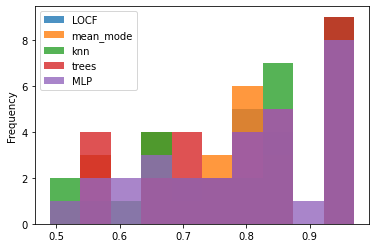

In [9]:
df_results.plot.hist(alpha=0.8) #hist

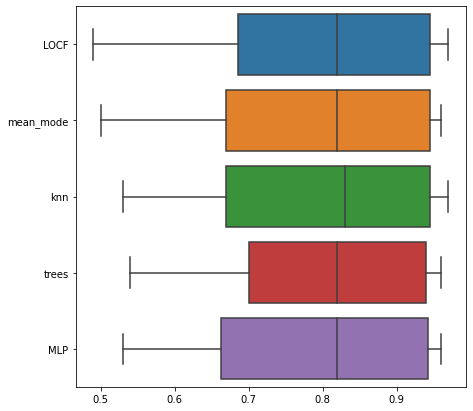

In [10]:
f, ax = plt.subplots(figsize=(7,7))
sns.boxplot(data=df_results,orient="h") #boxplot horizontal

Se puede observar que todos los métodos tienen una variación en un rango de 0.5 y 0.97, con media y mediana muy similar, pero aparentemente el método de imputación basado en arboles de decisión fue un poco mejor.

## Normalidad univariada:

In [11]:
#checa normalidad univariada
methods=df_results.columns
print('Shapiro test:')
for method in methods:
    W,p_v=stats.shapiro(df_results[method].values) #W>0.9 or p_v>0.05  Normalidad univariada 
    print('Method: '+method+' W: '+str(np.round(W,3))+' p_v: '+str(np.round(p_v,3)))

Shapiro test:
Method: LOCF W: 0.924 p_v: 0.034
Method: mean_mode W: 0.915 p_v: 0.02
Method: knn W: 0.914 p_v: 0.018
Method: trees W: 0.914 p_v: 0.019
Method: MLP W: 0.91 p_v: 0.015


Se rechaza la normalidad y la aproximamos por la transformación Box-Cox:

In [12]:
#aproximar a normal
pt1 = PowerTransformer(method='box-cox') #‘yeo-johnson’ boxcox solo positivos
pt1.fit(df_results.values) #estima los lambdas optimos para la transformacion
X_t=pt1.transform(df_results.values) #aplica la transformacion a los datos
df_results_norm=pd.DataFrame(X_t)
df_results_norm.columns=methods

In [13]:
#checa normalidad univariada
methods=df_results.columns
print('Shapiro test:')
for method in methods:
    W,p_v=stats.shapiro(df_results_norm[method].values) #W>0.9 or p_v>0.05  Normalidad univariada 
    print('Method: '+method+' W: '+str(np.round(W,3))+' p_v: '+str(np.round(p_v,3)))

Shapiro test:
Method: LOCF W: 0.925 p_v: 0.037
Method: mean_mode W: 0.914 p_v: 0.019
Method: knn W: 0.917 p_v: 0.022
Method: trees W: 0.915 p_v: 0.02
Method: MLP W: 0.912 p_v: 0.017


Aceptamos el supuesto de normalidad

## t-test para diferencia en medias al 5%: 

${H_0}:{\mu _1} - {\mu _2} = 0$


In [32]:
print('t-test para diferencia en medias al 5%:')
methods=list(df_results.columns)
methods2=list(df_results.columns)
for method1 in methods:
    for method2 in methods2:
        if method1 != method2:
            _,pvalue=stats.ttest_ind(df_results_norm[method1].values,df_results_norm[method2].values)
            print(method1+'-'+method2+' acepta H0 :'+str(np.round(pvalue,3)>0.05))
    methods2.remove(method1)

t-test para diferencia en medias al 5%:
LOCF-mean_mode acepta H0 :True
LOCF-knn acepta H0 :True
LOCF-trees acepta H0 :True
LOCF-MLP acepta H0 :True
mean_mode-knn acepta H0 :True
mean_mode-trees acepta H0 :True
mean_mode-MLP acepta H0 :True
knn-trees acepta H0 :True
knn-MLP acepta H0 :True
trees-MLP acepta H0 :True


Para este experimento, ningún método resultó significativamente diferente a otro

## Comparación Bayesiana:

Probabilities: LOCF: 0.1872 - mean_mode: 0.8128
Probabilities: LOCF: 0.10844 - knn: 0.89156
Probabilities: LOCF: 0.0678 - trees: 0.9322
Probabilities: LOCF: 0.5897 - MLP: 0.4103
Probabilities: mean_mode: 0.12784 - knn: 0.87216
Probabilities: mean_mode: 0.03838 - trees: 0.96162
Probabilities: mean_mode: 0.6185 - MLP: 0.3815
Probabilities: knn: 0.36664 - trees: 0.63336
Probabilities: knn: 0.93878 - MLP: 0.06122
Probabilities: trees: 0.94352 - MLP: 0.05648


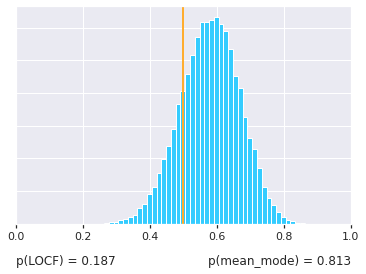

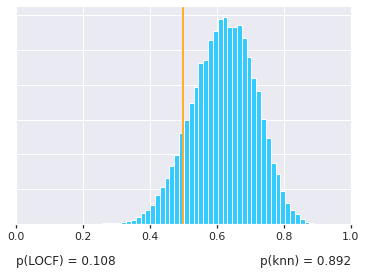

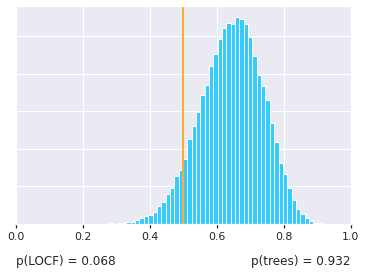

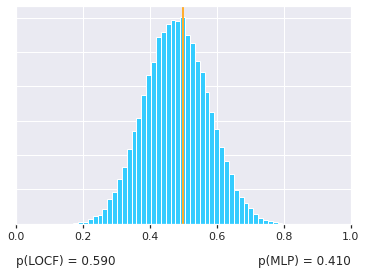

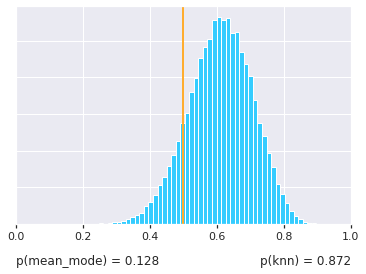

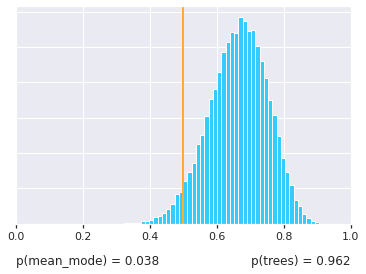

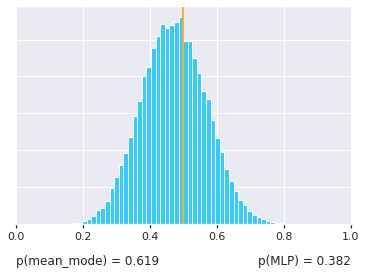

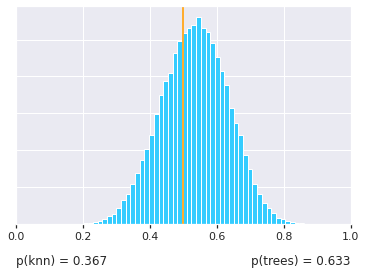

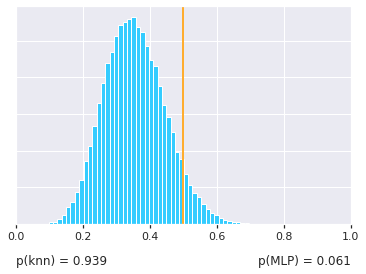

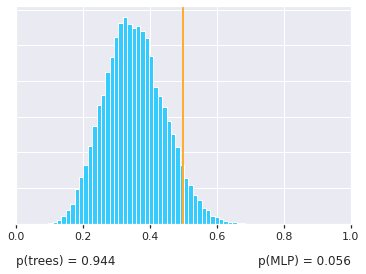

In [34]:
methods=list(df_results.columns)
methods2=list(df_results.columns)
for method1 in methods:
    for method2 in methods2:
        if method1 != method2:
            probs, fig=two_on_multiple(df_results[method1].values,df_results[method2].values,plot=True, names=(method1,method2))
            print('Probabilities: '+method1+': '+str(probs[0])+' - '+method2+': '+str(probs[2]))
    methods2.remove(method1)

Mediante la comparación bayesiana se puede observar que el método basado en arboles fue mejor que todos los demás, seguido de los métodos de vecinos más cercanos, media o moda, LOCF y finalmente el método basado en redes neuronales.  

## Conclusiones:

- El método basado en arboles fue el mejor en este experimento, algunas de las posibles causas son que para este método se realizo un ajuste por búsqueda aleatoria y se empleó regularización, además de las ventajas mismas de la implementación XGBoost la cual no necesita que el conjunto de datos sea estandarizado, el método de construcción de los arboles aprende con los datos que decisión tomar cuando hay valores ausentes y también como otros métodos basado en árboles,  estos logran captar cuales son las características más importantes en la construcción de los árboles.

- Por otro lado, el método basado en redes neuronales fue el peor, pero hay que considerar que en este caso no se empleó regularización, se utilizó un mismo modelo, es decir por tiempo computacional no se hizo búsqueda aleatoria sobre los parámetros para ajustar el mejor, esto pudo causar un ajuste pobre, además que los métodos de redes neuronales son especialmente buenos cuando se tiene una gran cantidad de datos y en este caso el tamaño máximo fue de 1000 aproximadamente lo cual es muy poco.

- Otro factor a considerar es que no se tomo en cuenta si había clases desbalanceadas, lo cual también afecta la clasificación.     